In [1]:
import numba
from numba import cuda
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
@cuda.jit
def slow_kernel(inputImage, kernel, outputImage, channels, w, h, kernelRows, kernelCols):
    r, c = cuda.grid(2) # Finding the global position of the thread
    kernelRowsRadius = kernelRows//2
    kernelColsRadius = kernelCols//2
    for b in range(BATCH):
        for ch in range(channels):
            opPixel = 0
            if r < h and c < w:
                startRow = r - kernelRowsRadius
                startCol = c - kernelColsRadius
                for i in range(kernelRows):
                    for j in range(kernelCols):
                        currentRow = startRow + i
                        currentCol = startCol + j
                        if currentRow >= 0 and currentRow < h and currentCol >= 0 and currentCol < w:
                            opPixel += inputImage[b, currentRow, currentCol, ch]*kernel[i, j]
            outputImage[b,r,c,ch] = opPixel

In [3]:
# img = cv2.imread('peacock.jpg')
# img = cv2.resize(img, (imgrows, imgcols))
# img_batch = []
# for i in range(BATCH):
#     img_batch.append(img)
# img_batch = np.array(img_batch)
# threadsperblock = (16, 16)
# blockspergrid = (np.ceil(imgrows/threadsperblock[0]).astype('int'), np.ceil(imgcols/threadsperblock[1]).astype('int'))
# print (threadsperblock)
# print (blockspergrid)

In [4]:
cap = cv2.VideoCapture('Kiiara.mp4')
imgrows = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
imgcols = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# imgrows = 2**7
# imgcols = 2**7

BATCH = 100
# BATCH = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
img_batch = []
for i in range(BATCH):
    ret, img = cap.read()
#     img = cv2.resize(img, (imgrows, imgcols))
    img_batch.append(img)
img_batch = np.array(img_batch)
threadsperblock = (16, 16)
blockspergrid = (np.ceil(imgrows/threadsperblock[0]).astype('int'), np.ceil(imgcols/threadsperblock[1]).astype('int'))
print (threadsperblock)
print (blockspergrid)

(16, 16)
(40, 23)


In [5]:
## Average
kernelwidth =  5
kernelheight = 5
kernel = np.ones((kernelwidth,kernelheight))
kernel /= kernelheight*kernelwidth
KERNEL_CONSTANT = kernel.copy()
### Laplacian
# kernel = np.array([[-1,-1,-1], [-1, 8 ,-1],[-1,-1,-1]]) 

### sharpen
# kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]]) 

# Edge detection
# kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]]) 


In [10]:
# stream = cuda.stream()
# start = time.time()
# with stream.auto_synchronize():
channels = 3
# start = cuda.event(timing = True)
# stop = cuda.event(timing = True)
# start.record()
inputImageGlobalMemory = cuda.to_device(img_batch)
kernelGlobalMemory = cuda.to_device(kernel)
outputImageGlobalMemory = cuda.device_array((BATCH ,imgcols, imgrows, channels))
slow_kernel[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,channels, imgrows, imgcols, kernelwidth, kernelheight)
# outputImage = outputImageGlobalMemory.copy_to_host()
# stop.record()
# To make executions async and when python exits the context
# syncronization happens

In [11]:
# start.record()
# slow_kernel[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,1, imgrows, imgcols, kernelwidth, kernelheight)
# stop.record()

outputImage = outputImageGlobalMemory.copy_to_host()
# print (start.elapsed_time(stop)*1e-3)


CudaAPIError: [700] Call to cuMemcpyDtoH results in UNKNOWN_CUDA_ERROR

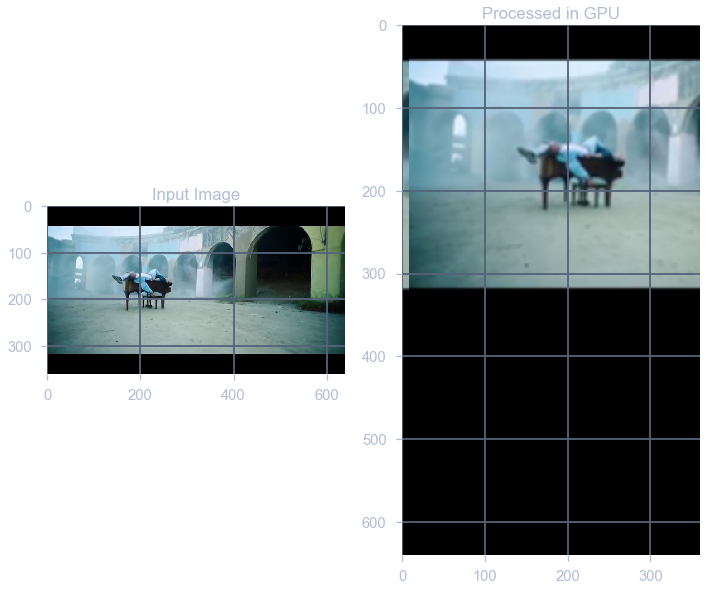

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_batch[55][:,:,::-1])
plt.title("Input Image")

plt.subplot(1,2,2)
plt.imshow(outputImage[55][:,:,::-1].astype('uint8'))
plt.title("Processed in GPU")
plt.tight_layout()
plt.show()

In [4]:
n_streams = 4
streams = []
CHANNEL = 3

# Creating a list of streams for Spatio Temporal parallelism
for i in range(n_streams):
    streams.append(cuda.stream())


# start = cuda.event(timing = True)
# stop = cuda.event(timing = True)

# Pumping data from CPU to GPU
for i in streams:
    
    inputImageGlobalMemory = cuda.to_device(img_batch,stream=i)

# start.record()
# Starting kernel Calls in CUDA streams 
for k in streams:
    kernelGlobalMemory = cuda.to_device(KERNEL_CONSTANT,stream=k)
    outputImageGlobalMemory = cuda.device_array((BATCH, imgrows, imgcols, CHANNEL),stream=k)
    # shared_conv[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,1, imgrows, imgcols)
    slow_kernel[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,CHANNEL, imgrows, imgcols, kernelwidth, kernelheight)
# stop.record()

# Getting data back to GPU from CPU
outputImage = outputImageGlobalMemory.copy_to_host()
# print (start.elapsed_time(stop)*1e-3)

NameError: name 'img_batch' is not defined

In [34]:
outputImage.shape

(100, 128, 128, 3)

In [ ]:
def process_video(group_number):
    cap = cv2.VideoCapture(args.input_file)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_jump_unit * group_number)
    proc_frames = 0
    out = cv2.VideoWriter(
        "{}.{}".format(group_number, args.extension),
        cv2.VideoWriter_fourcc(*vid_fourcc[args.extension]),
        fps,
        (width, height),
    )

    while proc_frames < frame_jump_unit:
        ret, frame = cap.read()
        if ret == False:
            break
        out.write(cv2.filter2D(frame, -1, kernel))
        proc_frames += 1

    cap.release()
    out.release()
    return None


In [7]:
n_streams = 10
streams = []
CHANNEL = 3
cap = cv2.VideoCapture('Kiiara.mp4')

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

frame_jump_unit = cap.get(cv2.CAP_PROP_FRAME_COUNT) // n_streams
BATCH = int(frame_jump_unit)

imgrows = int(width)
imgcols = int(height)

threadsperblock = (16, 16)
blockspergrid = (np.ceil(imgrows/threadsperblock[0]).astype('int'), np.ceil(imgcols/threadsperblock[1]).astype('int'))
print (threadsperblock)
print (blockspergrid)

fps = cap.get(cv2.CAP_PROP_FPS)
outputImage = np.ones((int(n_streams), BATCH , imgrows, imgcols, 3)).astype('int')

# Creating a list of streams for Spatio Temporal parallelism
for i in range(n_streams):
    streams.append(cuda.stream())


# start = cuda.event(timing = True)
# stop = cuda.event(timing = True)

# Pumping data from CPU to GPU
inputImageGlobalMemory = cuda.device_array((int(n_streams), BATCH , imgrows, imgcols, 3))
frame_jump_unit = cap.get(cv2.CAP_PROP_FRAME_COUNT) // n_streams
for idx, i in enumerate(streams):
    cap = cv2.VideoCapture('Kiiara.mp4')
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_jump_unit) * idx)
    proc_frames = 0
    img_batch = []
    while proc_frames < frame_jump_unit:
        ret, frame = cap.read()
        frame = cv2.resize(frame, (imgrows, imgcols))
        img_batch.append(frame)
        if ret == False:
            break
        proc_frames += 1
    inputImageGlobalMemory[idx] = cuda.to_device(img_batch,stream=i)
    print ("Input Streams "  + str(idx))
    i.synchronize()

# start.record()
# Starting kernel Calls in CUDA streams 
outputImageGlobalMemory = cuda.device_array(( int(n_streams), int(frame_jump_unit), imgrows, imgcols, CHANNEL))
for idx,k in enumerate(streams):
    kernelGlobalMemory = cuda.to_device(KERNEL_CONSTANT,stream=k)
#     outputImageGlobalMemory = cuda.device_array(( int(frame_jump_unit), imgrows, imgcols, CHANNEL),stream=k)
    # shared_conv[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,1, imgrows, imgcols)
    slow_kernel[blockspergrid, threadsperblock, k](inputImageGlobalMemory[idx], kernelGlobalMemory, outputImageGlobalMemory[idx],CHANNEL, imgrows, imgcols, kernelwidth, kernelheight)
    print ("Kernel Calls " + str(idx))
# stop.record()

for idx,k in enumerate(streams):
    # Getting data back to GPU from CPU
    outputImage[idx] = outputImageGlobalMemory[idx].copy_to_host(stream=k)
    print ("Output Streams " + str(idx))
    out = cv2.VideoWriter(
    "output/{}.{}".format(str(idx), 'avi'),
    cv2.VideoWriter_fourcc(*'MJPG'),
    fps,
    (imgrows, imgcols),
    )
    k.synchronize()
    for img_out in outputImage[idx]:
        out.write(img_out.astype('uint8'))
    out.release()
    # print (start.elapsed_time(stop)*1e-3)

(16, 16)
(40, 23)


MemoryError: 

In [8]:
n_streams = 10
streams = []
CHANNEL = 3
cap = cv2.VideoCapture('Kiiara.mp4')

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

frame_jump_unit = cap.get(cv2.CAP_PROP_FRAME_COUNT) // n_streams
BATCH = int(frame_jump_unit)

imgrows = int(width)
imgcols = int(height)

threadsperblock = (16, 16)
blockspergrid = (np.ceil(imgrows/threadsperblock[0]).astype('int'), np.ceil(imgcols/threadsperblock[1]).astype('int'))
print (threadsperblock)
print (blockspergrid)

fps = cap.get(cv2.CAP_PROP_FPS)
outputImage = np.ones((1, BATCH , imgrows, imgcols, 3)).astype('int')

# Creating a list of streams for Spatio Temporal parallelism
for i in range(n_streams):
    streams.append(cuda.stream())


# start = cuda.event(timing = True)
# stop = cuda.event(timing = True)

# Pumping data from CPU to GPU
inputImageGlobalMemory = cuda.device_array((int(n_streams), BATCH , imgrows, imgcols, 3))
outputImageGlobalMemory = cuda.device_array(( int(n_streams), int(frame_jump_unit), imgrows, imgcols, CHANNEL))
frame_jump_unit = cap.get(cv2.CAP_PROP_FRAME_COUNT) // n_streams
for idx, i in enumerate(streams):
    print ("Opening CAP")
    cap = cv2.VideoCapture('Kiiara.mp4')
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_jump_unit) * idx)
    proc_frames = 0
    img_batch = []
    print ("starting to load")
    while proc_frames < frame_jump_unit:
        ret, frame = cap.read()
        frame = cv2.resize(frame, (imgrows, imgcols))
        img_batch.append(frame)
        if ret == False:
            break
        proc_frames += 1
    print ("Done Loafing")
    inputImageGlobalMemory[idx] = cuda.to_device(img_batch,stream=i)
    print ("Input Streams "  + str(idx))
#     i.synchronize()

    kernelGlobalMemory = cuda.to_device(KERNEL_CONSTANT,stream=i)
    # shared_conv[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,1, imgrows, imgcols)
    slow_kernel[blockspergrid, threadsperblock, i](inputImageGlobalMemory[idx], kernelGlobalMemory, outputImageGlobalMemory[idx],CHANNEL, imgrows, imgcols, kernelwidth, kernelheight)
    print ("Kernel Calls " + str(idx))

    # Getting data back to GPU from CPU
    outputImage[0] = outputImageGlobalMemory[idx].copy_to_host(stream=i)
    print ("Output Streams " + str(idx))
    out = cv2.VideoWriter(
    "output/{}.{}".format(str(idx), 'avi'),
    cv2.VideoWriter_fourcc(*'MJPG'),
    fps,
    (imgrows, imgcols),
    )
    i.synchronize()
    for img_out in outputImage[idx]:
        out.write(img_out.astype('uint8'))
    out.release()
    # print (start.elapsed_time(stop)*1e-3)

(16, 16)
(40, 23)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



(16, 16)
(40, 23)
Opening CAP
starting to load
Done Loafing
(34, 360, 640, 3)
Input Streams 0
Kernel Calls 0
Output Streams 0


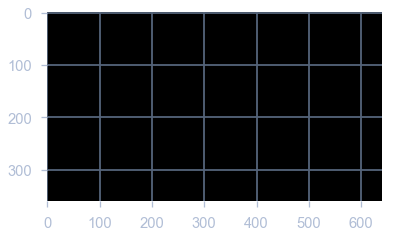

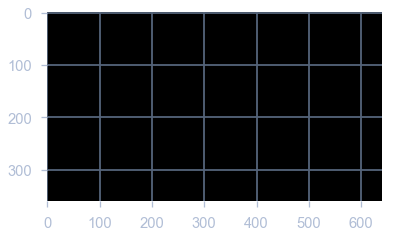

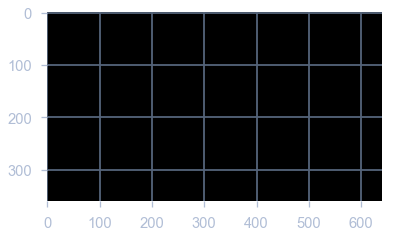

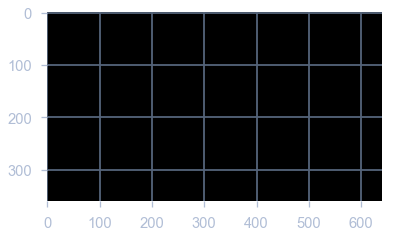

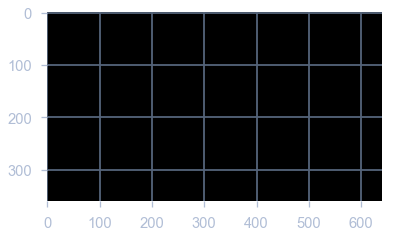

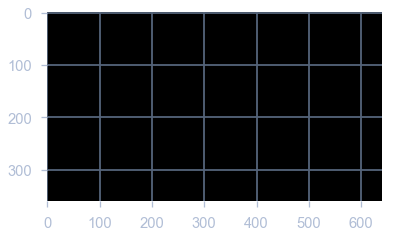

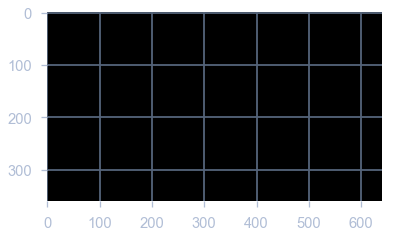

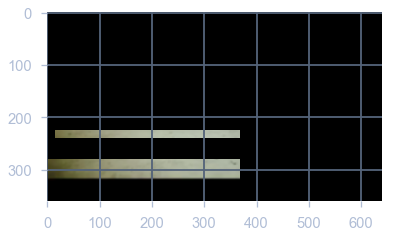

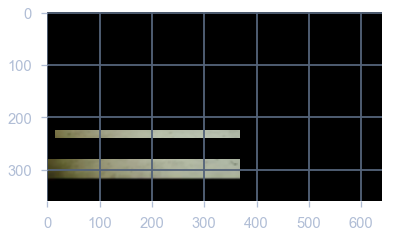

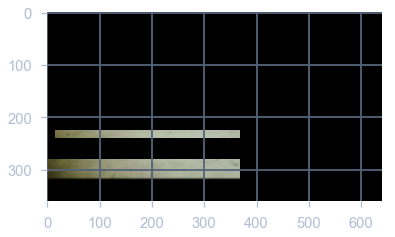

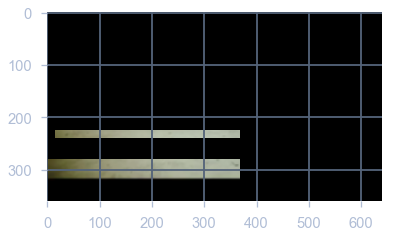

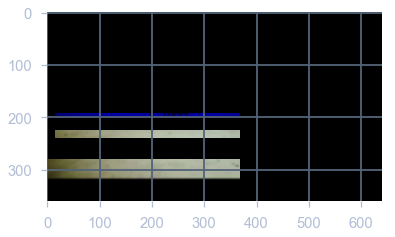

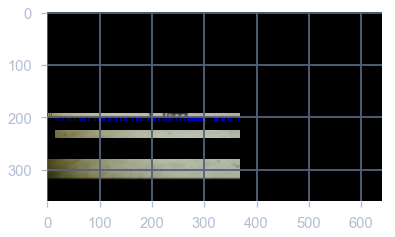

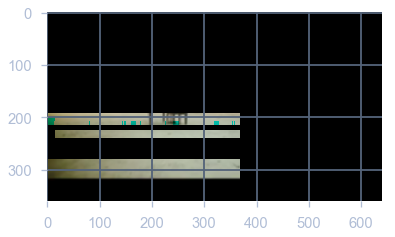

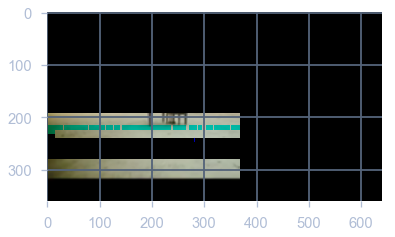

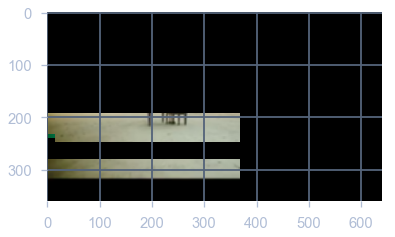

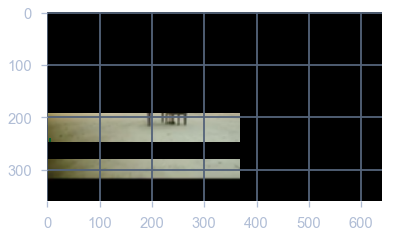

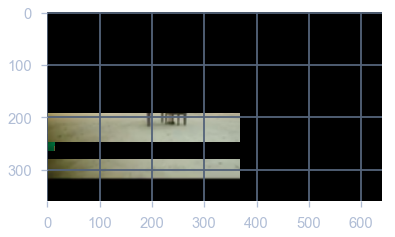

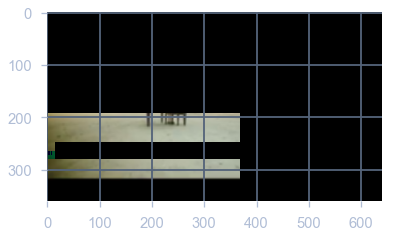

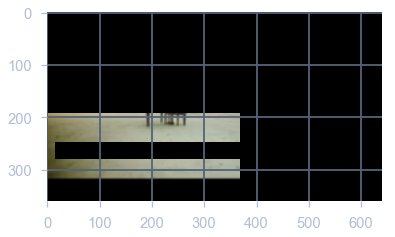

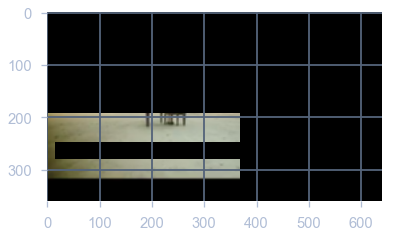

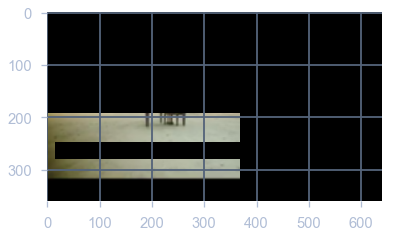

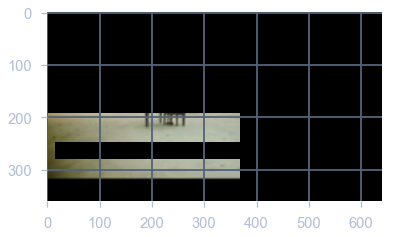

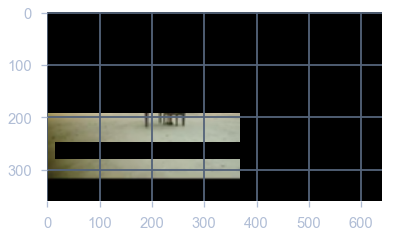

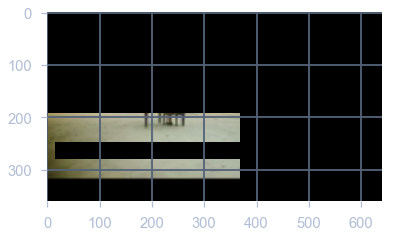

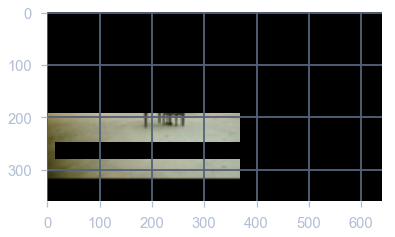

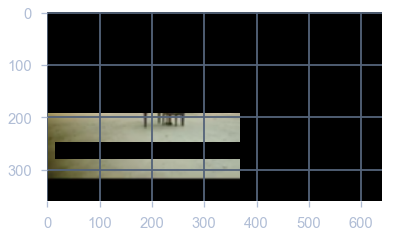

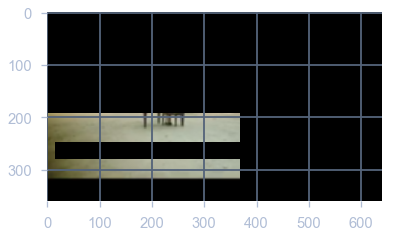

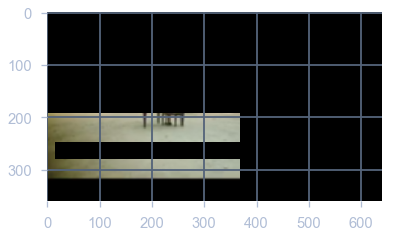

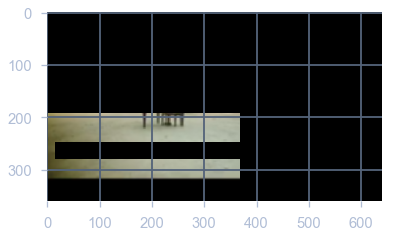

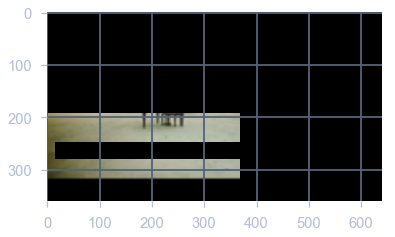

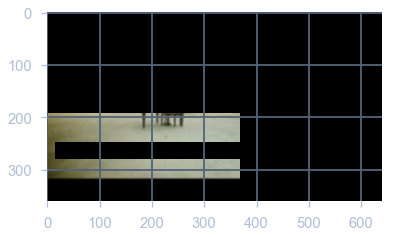

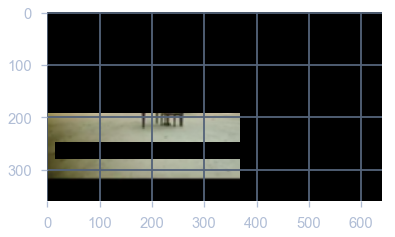

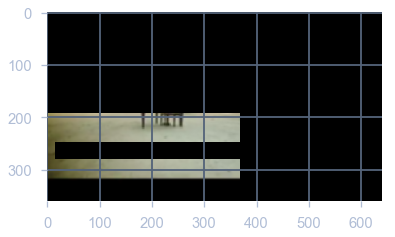

Opening CAP
starting to load
Done Loafing
(34, 360, 640, 3)
Input Streams 1
Kernel Calls 0
Output Streams 1


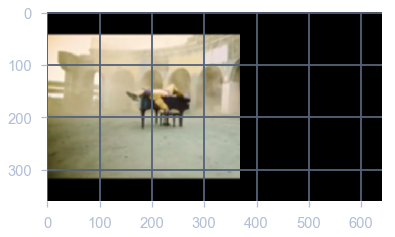

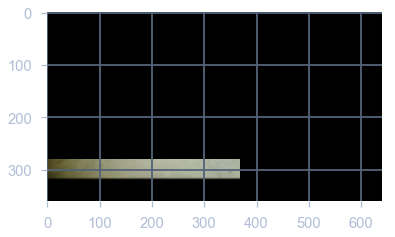

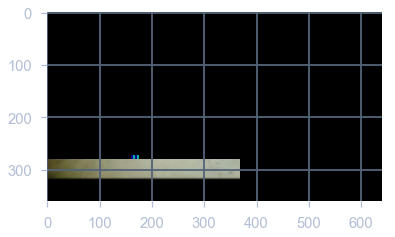

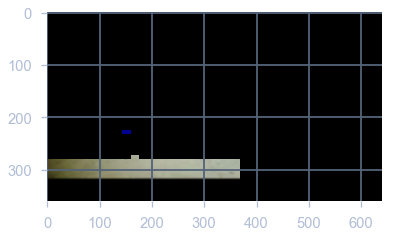

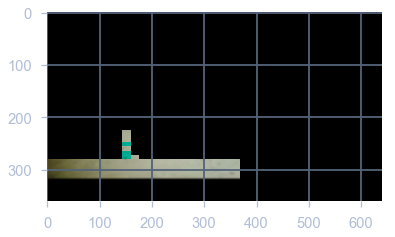

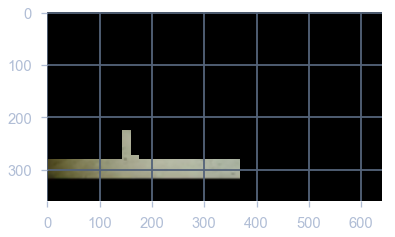

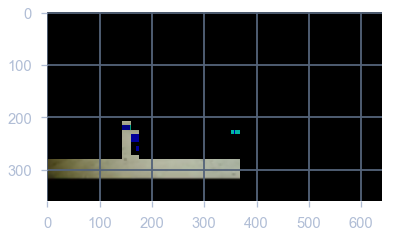

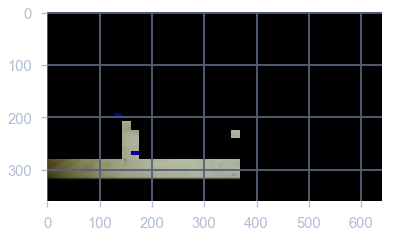

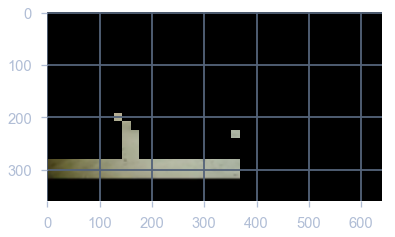

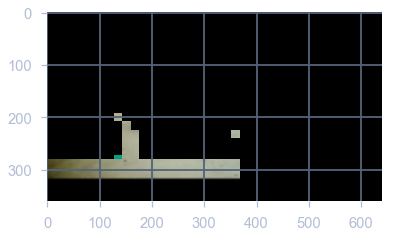

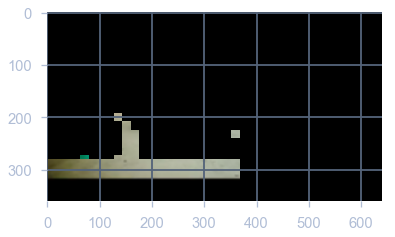

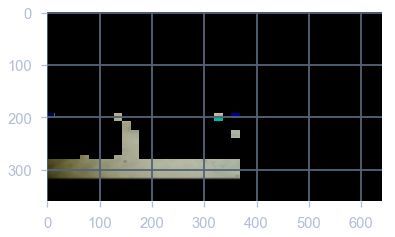

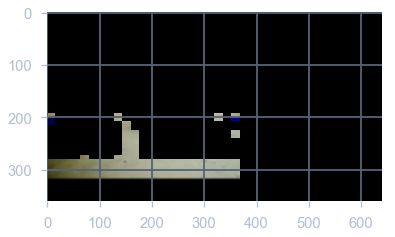

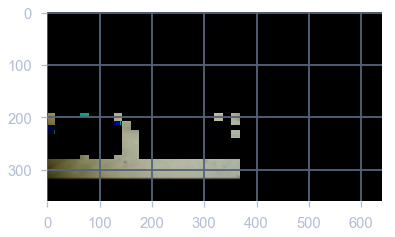

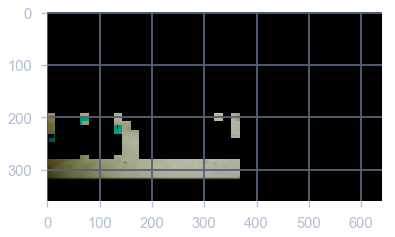

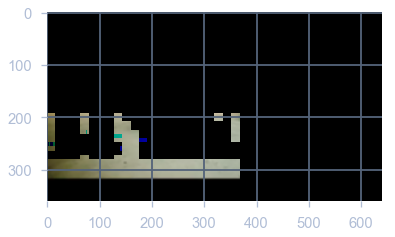

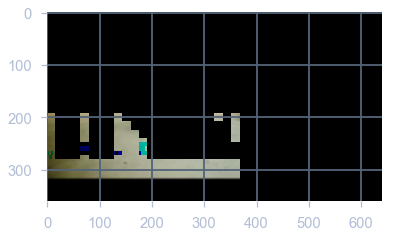

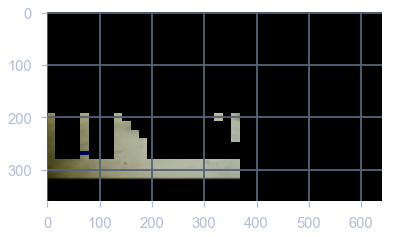

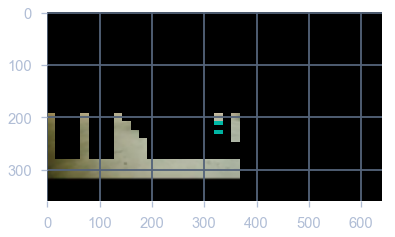

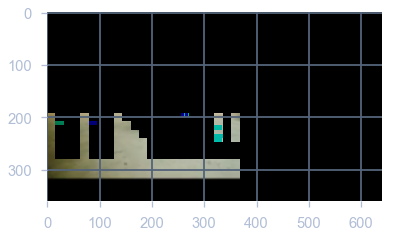

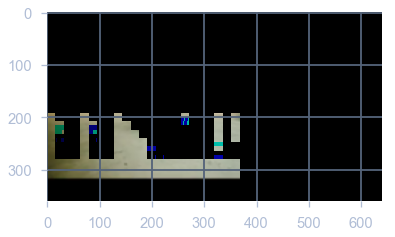

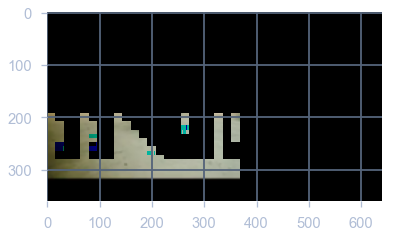

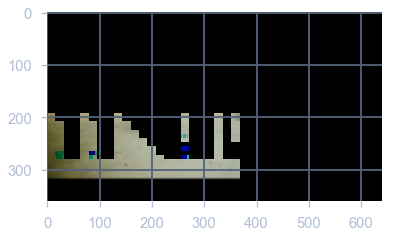

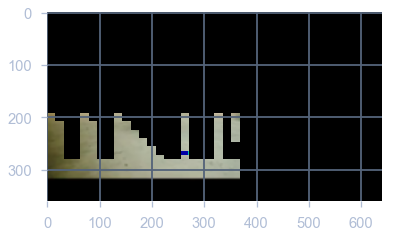

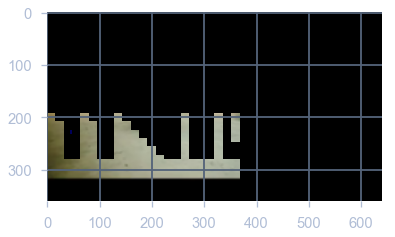

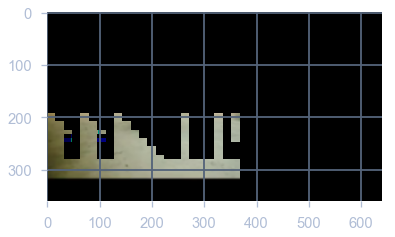

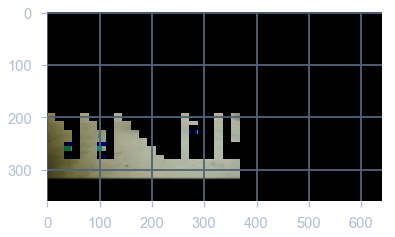

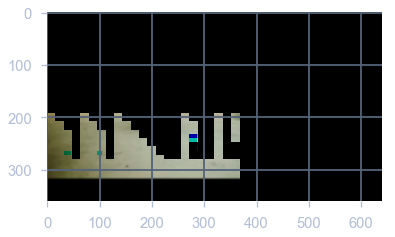

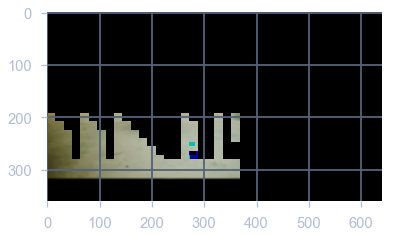

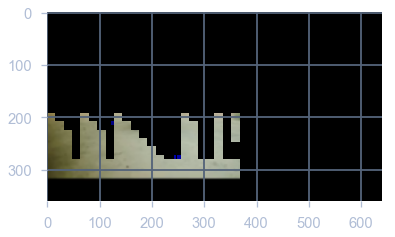

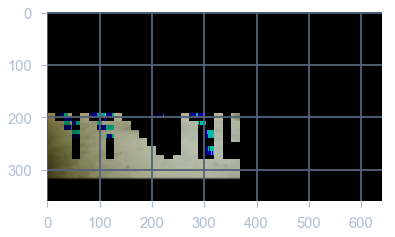

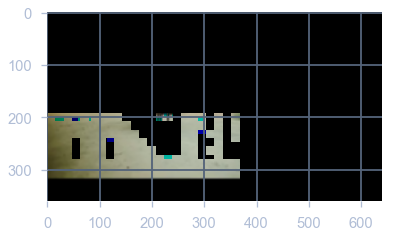

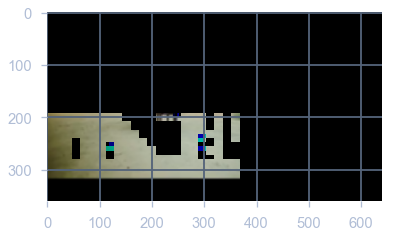

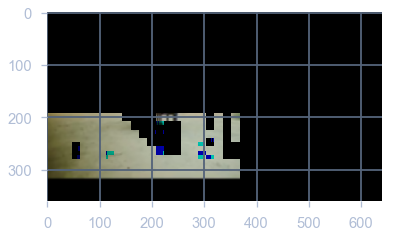

Opening CAP
starting to load
Done Loafing
(34, 360, 640, 3)
Input Streams 2
Kernel Calls 0
Output Streams 2


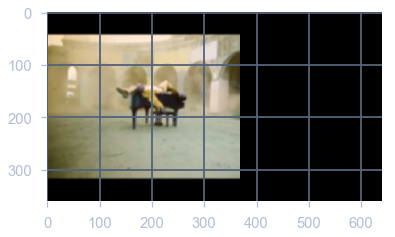

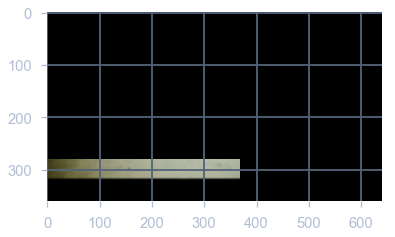

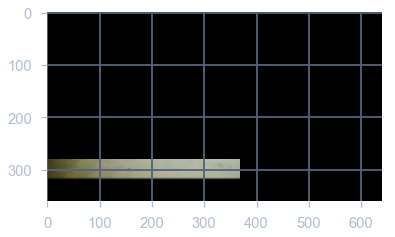

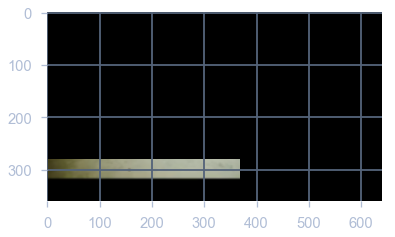

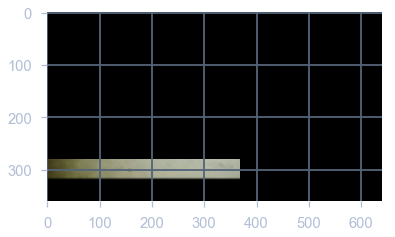

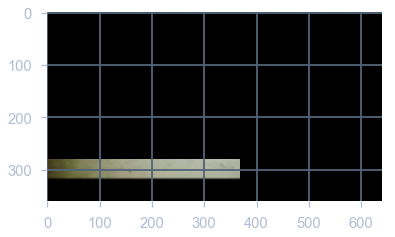

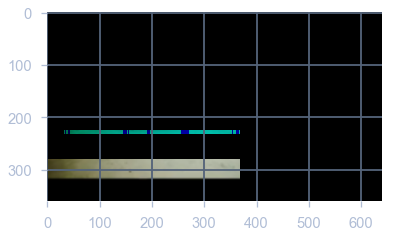

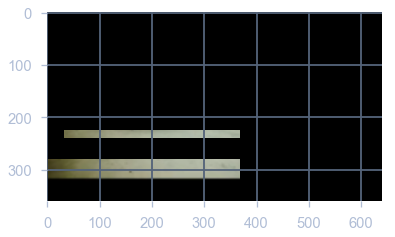

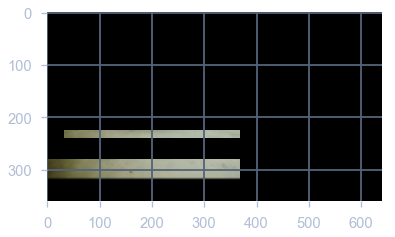

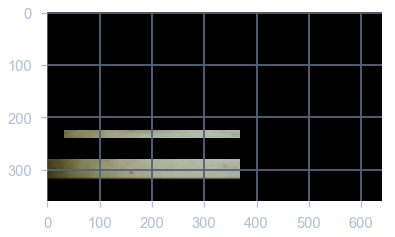

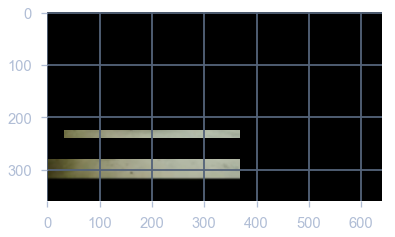

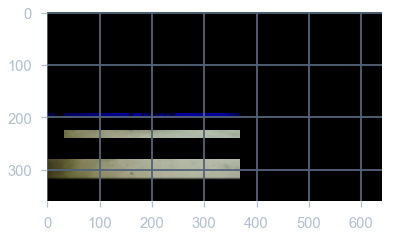

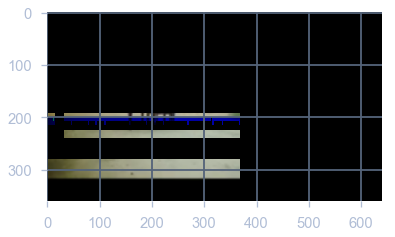

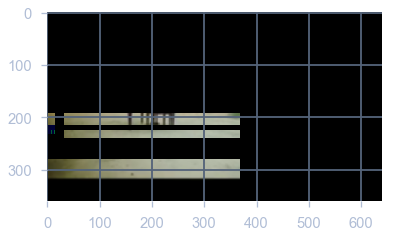

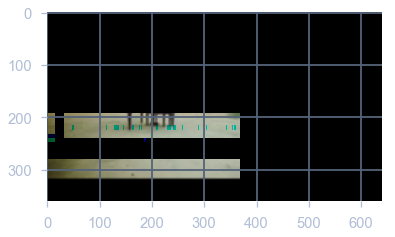

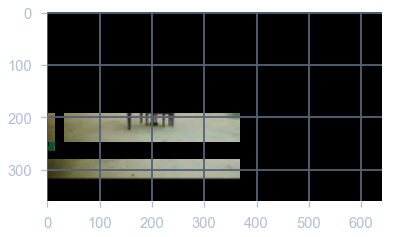

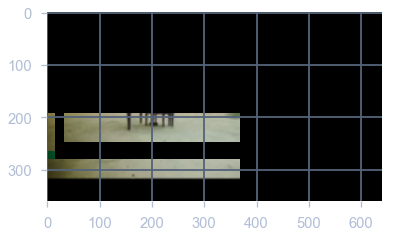

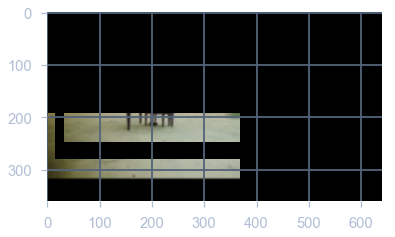

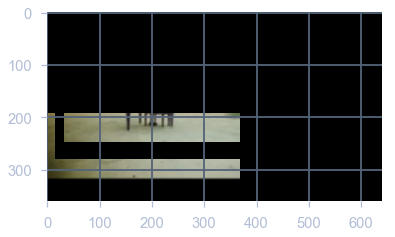

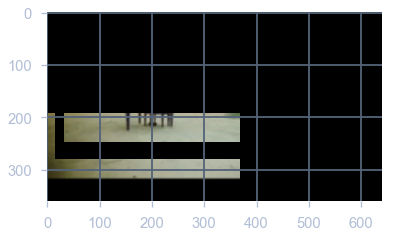

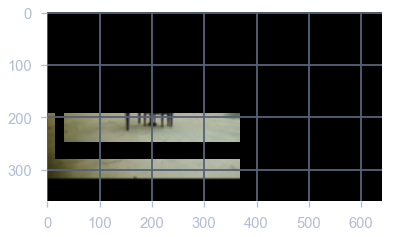

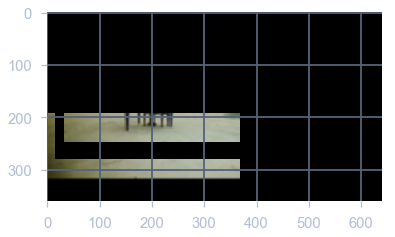

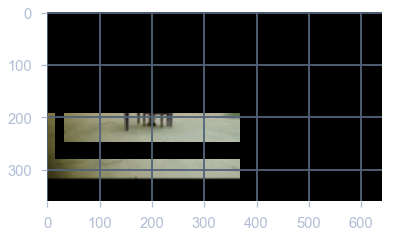

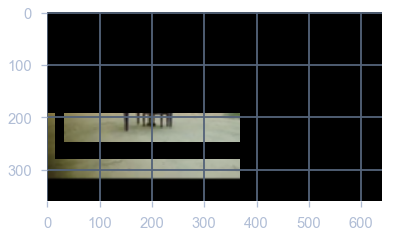

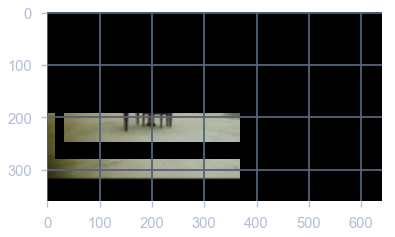

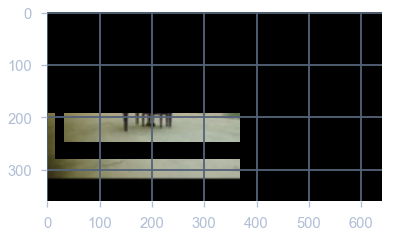

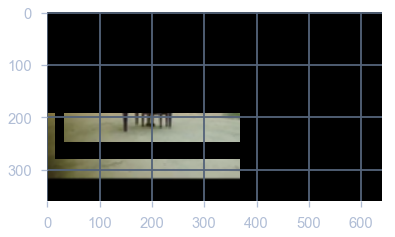

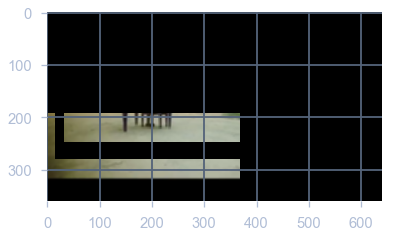

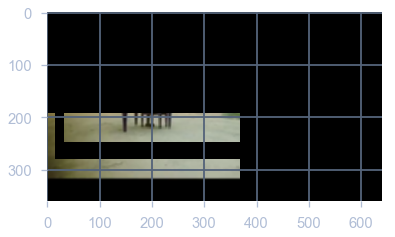

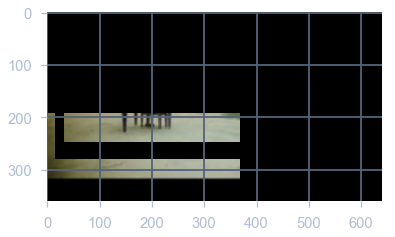

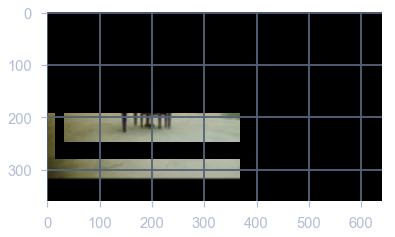

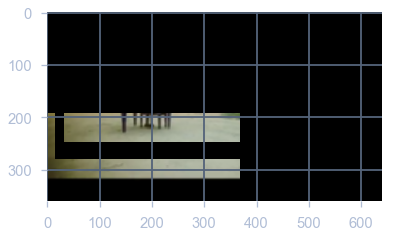

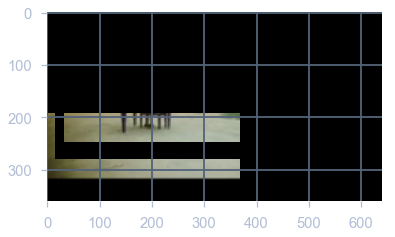

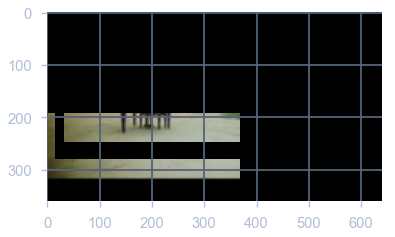

Opening CAP
starting to load
Done Loafing
(34, 360, 640, 3)
Input Streams 3
Kernel Calls 0
Output Streams 3


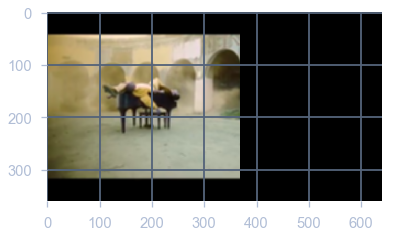

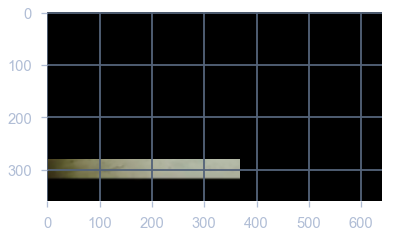

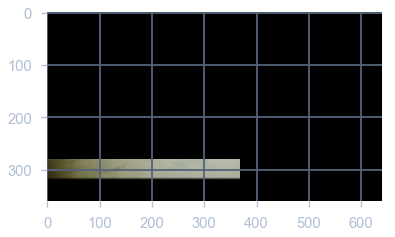

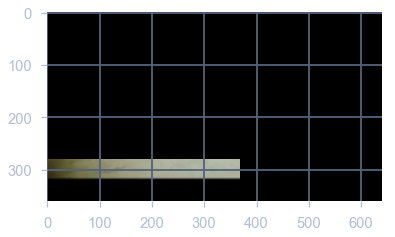

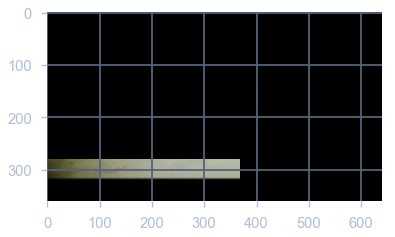

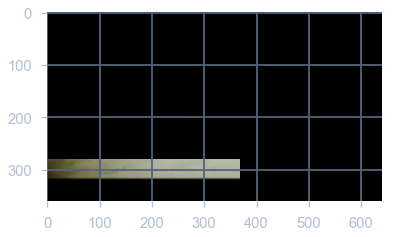

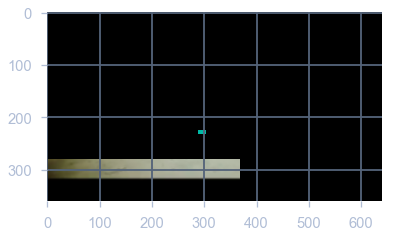

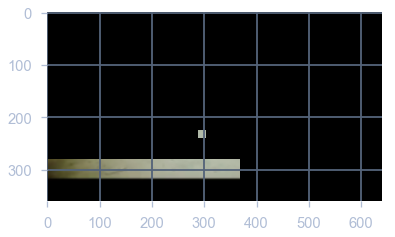

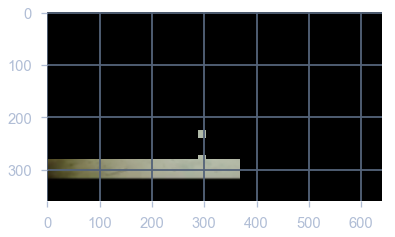

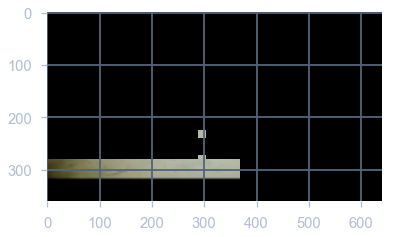

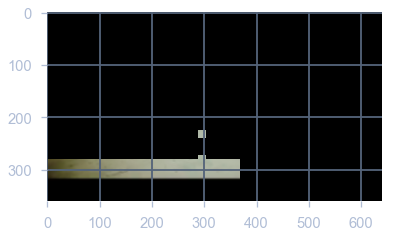

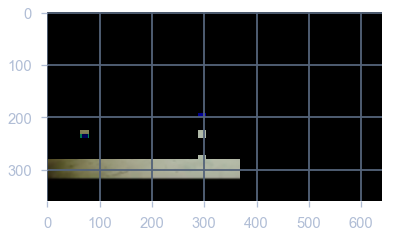

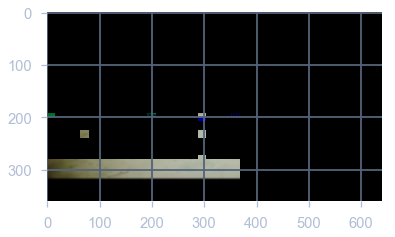

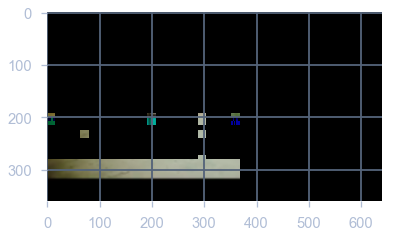

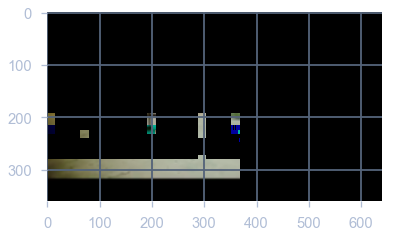

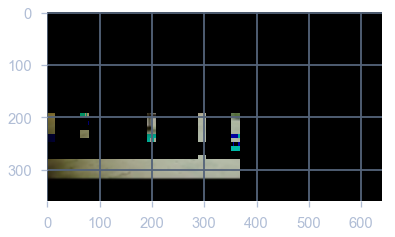

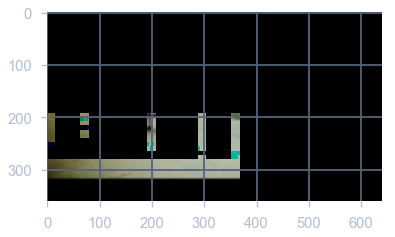

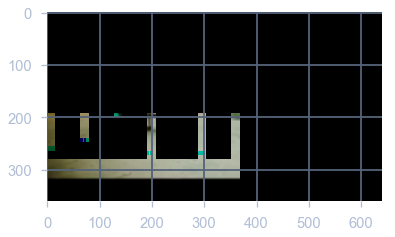

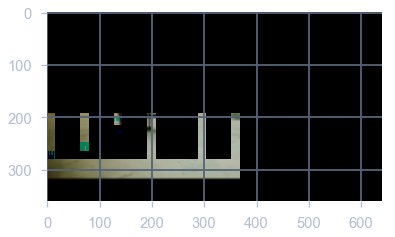

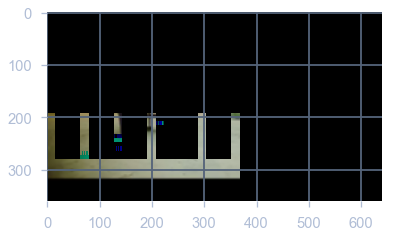

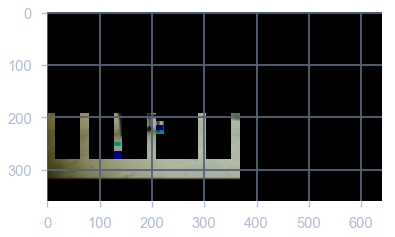

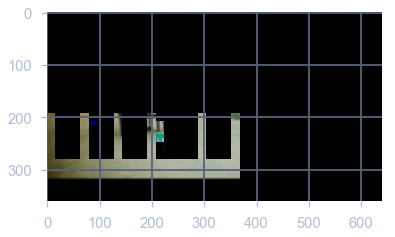

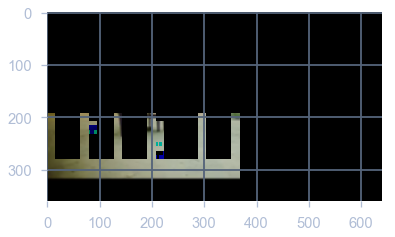

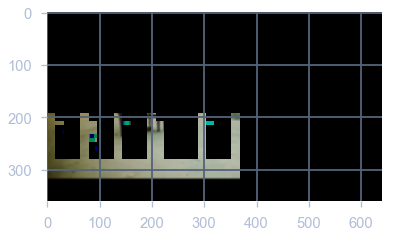

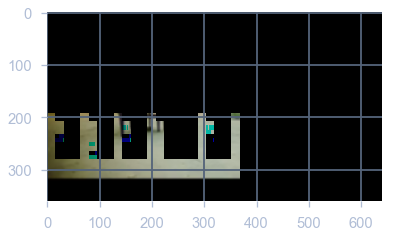

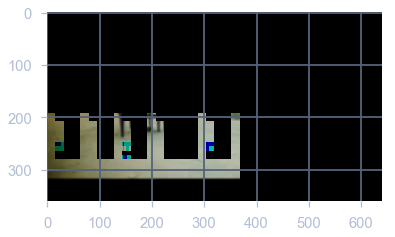

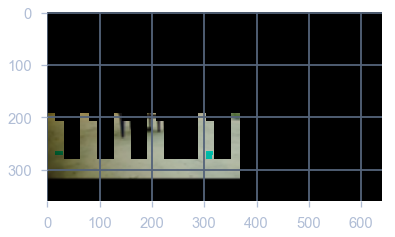

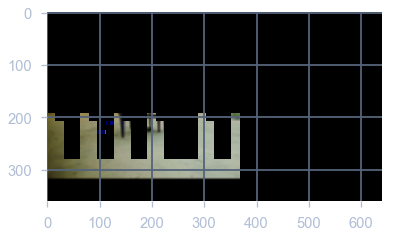

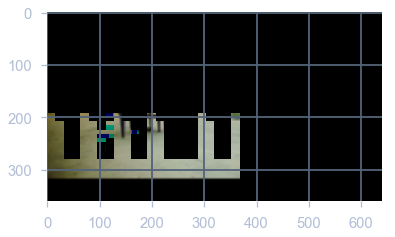

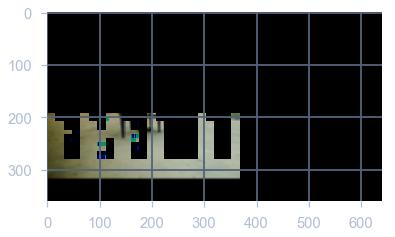

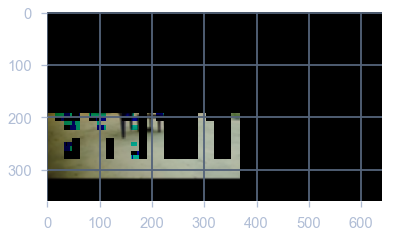

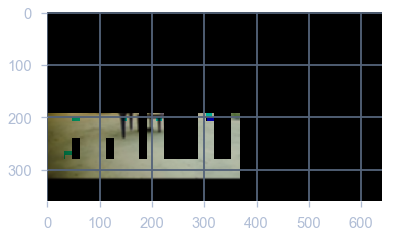

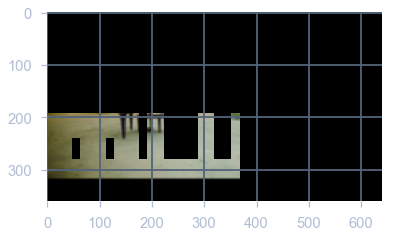

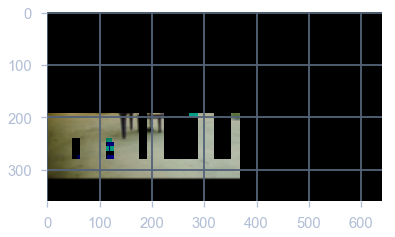

Opening CAP
starting to load
Done Loafing
(34, 360, 640, 3)
Input Streams 4
Kernel Calls 0
Output Streams 4


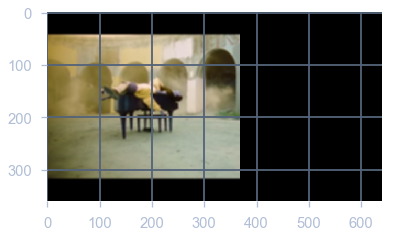

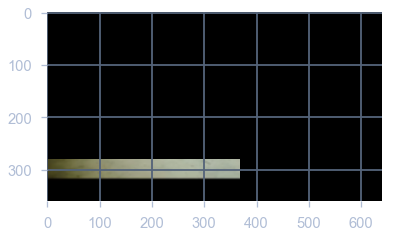

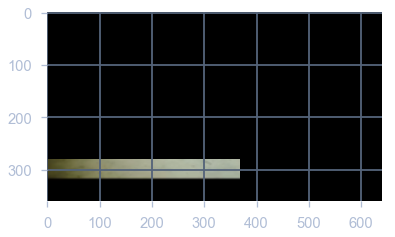

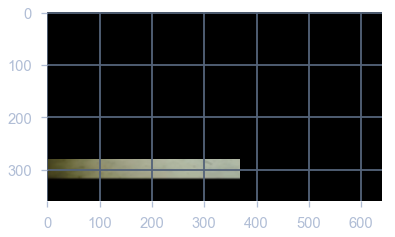

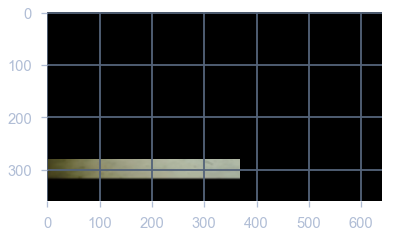

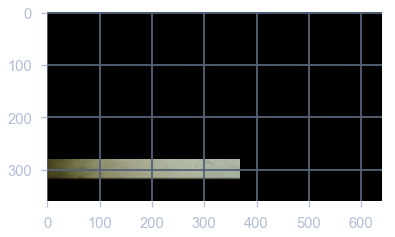

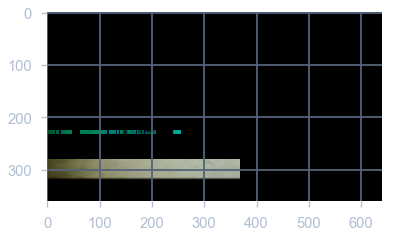

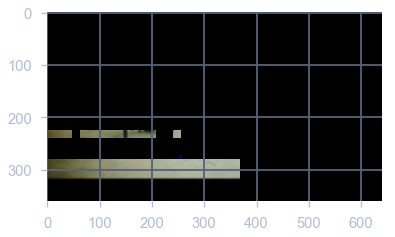

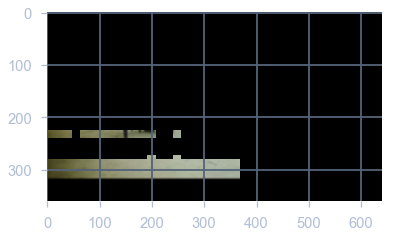

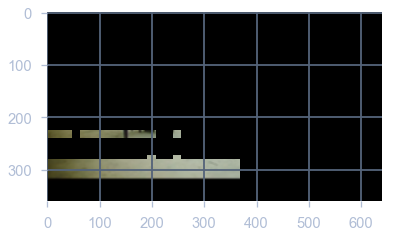

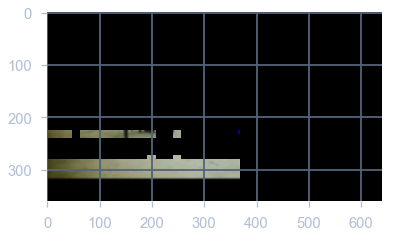

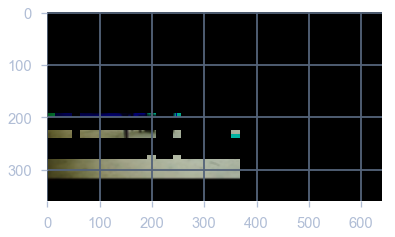

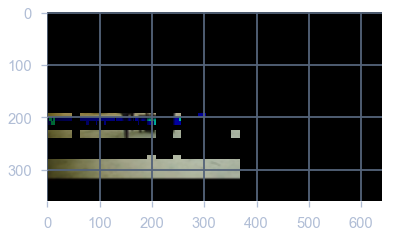

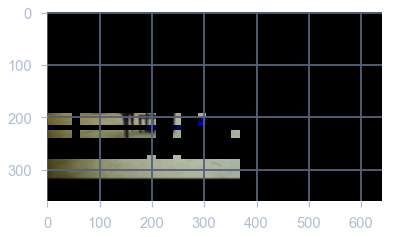

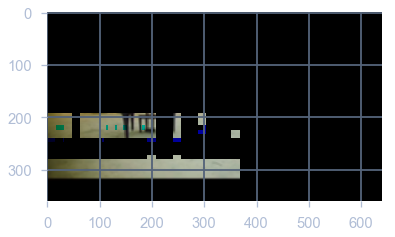

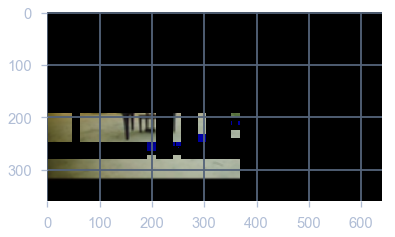

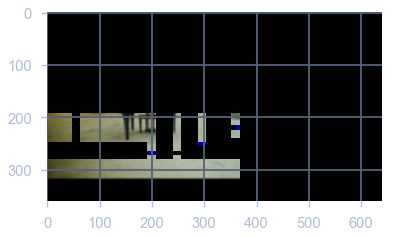

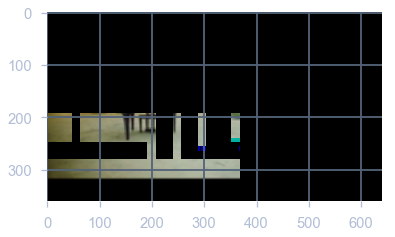

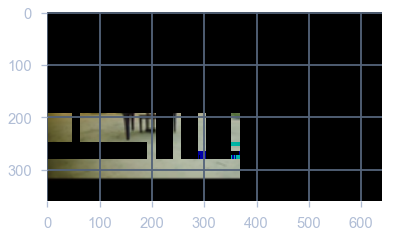

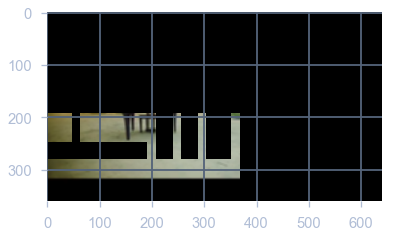

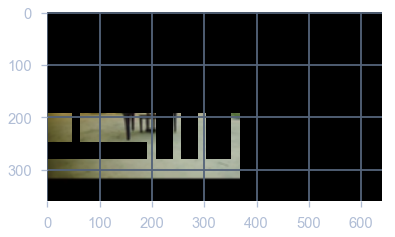

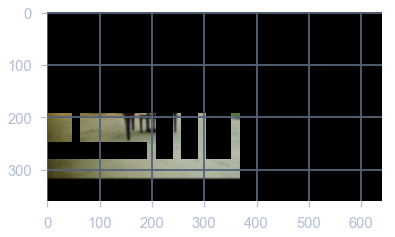

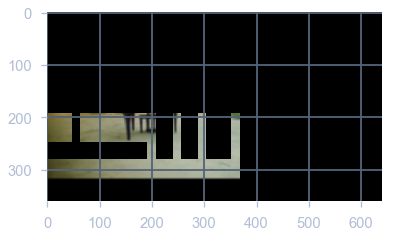

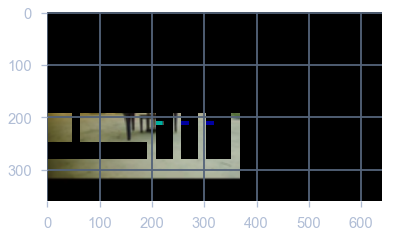

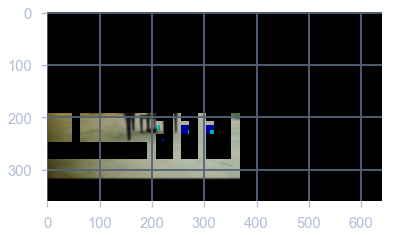

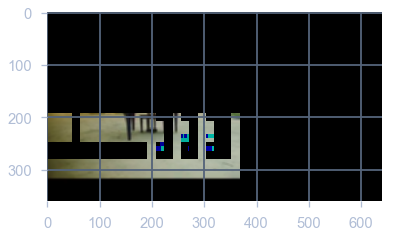

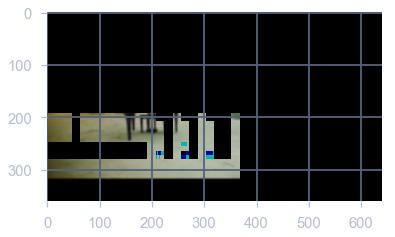

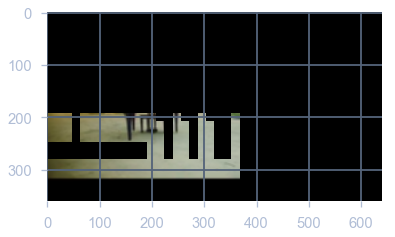

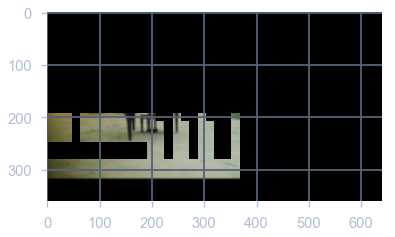

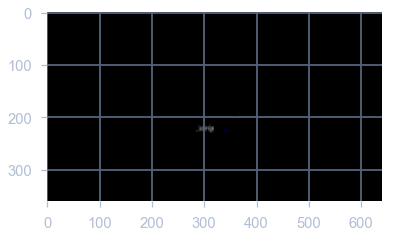

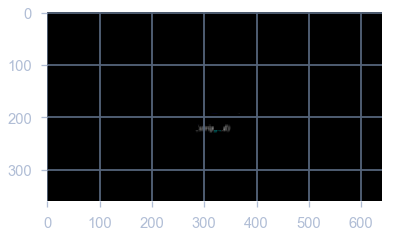

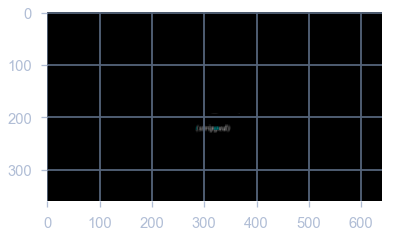

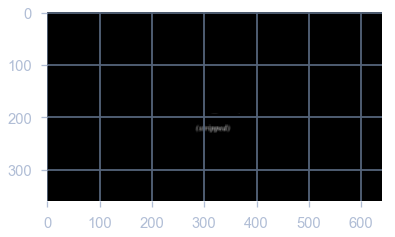

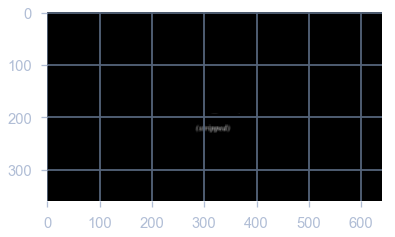

Opening CAP
starting to load
Done Loafing
(34, 360, 640, 3)
Input Streams 5
Kernel Calls 0


CudaAPIError: [700] Call to cuCtxSynchronize results in UNKNOWN_CUDA_ERROR

In [9]:
n_streams = 100
streams = []
CHANNEL = 3
cap = cv2.VideoCapture('Kiiara.mp4')

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

frame_jump_unit = cap.get(cv2.CAP_PROP_FRAME_COUNT) // n_streams
BATCH = int(frame_jump_unit)

imgrows = int(width)
imgcols = int(height)

threadsperblock = (16, 16)
blockspergrid = (np.ceil(imgrows/threadsperblock[0]).astype('int'), np.ceil(imgcols/threadsperblock[1]).astype('int'))
print (threadsperblock)
print (blockspergrid)

fps = cap.get(cv2.CAP_PROP_FPS)
outputImage = np.ones((1, BATCH , imgcols, imgrows, 3)).astype('int')

# start = cuda.event(timing = True)
# stop = cuda.event(timing = True)

# Pumping data from CPU to GPU
inputImageGlobalMemory = cuda.device_array((1, BATCH , imgcols, imgrows, 3))
outputImageGlobalMemory = cuda.device_array(( 1, int(frame_jump_unit), imgcols, imgrows, CHANNEL))
frame_jump_unit = cap.get(cv2.CAP_PROP_FRAME_COUNT) // n_streams
for idx in range(n_streams):
    print ("Opening CAP")
    cap = cv2.VideoCapture('Kiiara.mp4')
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_jump_unit) * idx)
    proc_frames = 0
    img_batch = []
    print ("starting to load")
    while proc_frames < frame_jump_unit:
        ret, frame = cap.read()
#         print (frame.shape)
        frame = cv2.resize(frame, (imgrows, imgcols))
        img_batch.append(frame)
        if ret == False:
            break
        proc_frames += 1
    print ("Done Loafing")
    print (np.array(img_batch).shape)
    inputImageGlobalMemory[0] = cuda.to_device(img_batch)
    print ("Input Streams "  + str(idx))
#     i.synchronize()

    kernelGlobalMemory = cuda.to_device(KERNEL_CONSTANT)
    # shared_conv[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,1, imgrows, imgcols)
    slow_kernel[blockspergrid, threadsperblock](inputImageGlobalMemory[0], kernelGlobalMemory, outputImageGlobalMemory[0],CHANNEL, imgrows, imgcols, kernelwidth, kernelheight)
    print ("Kernel Calls " + str(0))

    # Getting data back to GPU from CPU
    cuda.synchronize()
    outputImage[0] = outputImageGlobalMemory[0].copy_to_host()
    cuda.synchronize()
    print ("Output Streams " + str(idx))
    out = cv2.VideoWriter(
    "output/{}.{}".format(str(idx), 'avi'),
    cv2.VideoWriter_fourcc(*'MJPG'),
    fps,
    (imgrows, imgcols),
    )
    for img_out in outputImage[0]:
        plt.imshow(img_out)
        plt.show()
        out.write(img_out.astype('uint8'))
    out.release()
    # print (start.elapsed_time(stop)*1e-3)

In [10]:
import subprocess as sp
intermediate_files = ["{}.{}".format(i, "avi") for i in range(4)]
with open("intermediate_files.txt", "w") as f:
    for t in intermediate_files:
        f.write("file {} \n".format(t))

ffmpeg_command = "ffmpeg -y -loglevel error -f concat -safe 0 -i intermediate_files.txt".format().strip()
# if args.x264 == False:
ffmpeg_command += " -vcodec copy"
# else:
#     ffmpeg_command += " -vcodec libx264"
ffmpeg_command += " output_method2.{}".format('avi')
t2 = time.time()
sp.Popen(ffmpeg_command, shell=True).wait()
t3 = time.time()

from os import remove

for f in intermediate_files:
    remove(f)
remove("intermediate_files.txt")

In [28]:

out = cv2.VideoWriter(
    "{}.{}".format(str(0), 'avi'),
    cv2.VideoWriter_fourcc(*'MJPG'),
    fps,
    (imgrows, imgcols),
    )
for img_out in outputImage[0]:
    out.write(img_out.astype('uint8'))
out.release()

In [27]:

# cv2.imshow("iamge", outputImage[0][750])
# cv2.waitKey(0)

int64


In [ ]:
start = time.time()
op_image = []
for i in range(BATCH):
    op_image.append(cv2.filter2D(img_batch[i],-1,kernel))
print (time.time() - start)

In [66]:
cv2.imwrite("output.jpg", outputImage.astype('int'))
cv2.imwrite("input.jpg", img)

True

In [78]:
KERNEL = 3
O_TILE_WIDTH = 8
BLOCK_WIDTH =  O_TILE_WIDTH + KERNEL - 1
CHANNEL = 3

In [79]:
# ### Average
kernel = np.ones((KERNEL,KERNEL))
kernel /= KERNEL*KERNEL

## Laplacian
# kernel = np.array([[-1,-1,-1], [-1, 8 ,-1],[-1,-1,-1]]) 

### sharpen
# kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]]) 

# Edge detection
# kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]]) 


In [40]:
@cuda.jit
def shared_conv(inputImage, kernel, outputImage, channels, w, h):
    
    Ns = cuda.shared.array(shape=(BLOCK_WIDTH, BLOCK_WIDTH), dtype=numba.uint8)
    
    r, c  = cuda.grid(2)
    KERNEL_RADIUS = KERNEL//2
    
    # Need to load cooperatively [blockDim.x + Kernelrowradius , blockDim.y + Kernelcolsradius]
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    # Calculating the output tile's row and col coordinates
    row_o = cuda.blockIdx.y*O_TILE_WIDTH + ty
    col_o = cuda.blockIdx.x*O_TILE_WIDTH + tx
    
    # Shifting the coordinate system to corresponding input tile 
    row_i = row_o - KERNEL_RADIUS
    col_i = col_o - KERNEL_RADIUS
    
    output = 0.0
    
    # Taking care of boundaries
    if (row_i >= 0 and row_i < h and col_i >=0  and col_i < w):
        Ns[ty][tx] = inputImage[row_i, col_i]
    else:
        Ns[ty][tx] = 0
    
    # Some threads do not participate in calclating the output
    if (ty < O_TILE_WIDTH and tx < O_TILE_WIDTH):
        for i in range(KERNEL):
            for j in range(KERNEL):
                output+= Ns[i+ty][j+tx]*kernel[i][j]
        if row_o < w and col_o < h:
            outputImage[row_o, col_o] = output
    

In [41]:
@cuda.jit
def shared_conv_color(inputImage, kernel, outputImage, channels, w, h):
    
    Ns = cuda.shared.array(shape=(BATCH, BLOCK_WIDTH, BLOCK_WIDTH, CHANNEL), dtype=numba.uint8)
    
    r, c  = cuda.grid(2)
    KERNEL_RADIUS = KERNEL//2
    
    # Need to load cooperatively [blockDim.x + Kernelrowradius , blockDim.y + Kernelcolsradius]
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    # Calculating the output tile's row and col coordinates
    row_o = cuda.blockIdx.y*O_TILE_WIDTH + ty
    col_o = cuda.blockIdx.x*O_TILE_WIDTH + tx
    
    # Shifting the coordinate system to corresponding input tile 
    row_i = row_o - KERNEL_RADIUS
    col_i = col_o - KERNEL_RADIUS
    
    output = 0.0
    
    # Taking care of boundaries
    if (row_i >= 0 and row_i < h and col_i >=0  and col_i < w):
        for b in range(BATCH):
            for ch in range(CHANNEL):
                Ns[b, ty, tx, ch] = inputImage[b, row_i, col_i, ch]
    else:
        for b in range(BATCH):
            for ch in range(CHANNEL):
                Ns[b, ty, tx, ch] = 0
    
    # Some threads do not participate in calclating the output
    for b in range(BATCH):
        for ch in range(CHANNEL):
            output = 0.0
            if (ty < O_TILE_WIDTH and tx < O_TILE_WIDTH):
                for i in range(KERNEL):
                    for j in range(KERNEL):
                        output+= Ns[b, i+ty, j+tx, ch]*kernel[i][j]
                if row_o < w and col_o < h:
                    outputImage[b, row_o, col_o, ch] = output

In [82]:
img = cv2.imread('peacock.jpg')
img = cv2.resize(img, (imgrows, imgcols))
threadsperblock = (BLOCK_WIDTH , BLOCK_WIDTH)
blockspergrid = (np.ceil(imgrows/O_TILE_WIDTH).astype('int'), np.ceil(imgcols/O_TILE_WIDTH).astype('int'))
print (threadsperblock)
print (blockspergrid)

(10, 10)
(16, 16)


In [88]:
start = cuda.event(timing = True)
stop = cuda.event(timing = True)
inputImageGlobalMemory = cuda.to_device(img_batch)
kernelGlobalMemory = cuda.to_device(kernel)
outputImageGlobalMemory = cuda.device_array((BATCH, imgrows, imgcols, CHANNEL))

start.record()
# shared_conv[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,1, imgrows, imgcols)
shared_conv_color[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,CHANNEL, imgrows, imgcols)
stop.record()

outputImage = outputImageGlobalMemory.copy_to_host()
print (start.elapsed_time(stop)*1e-3)
# To make executions async and when python exits the context
# syncronization happens

0.044943103790283205


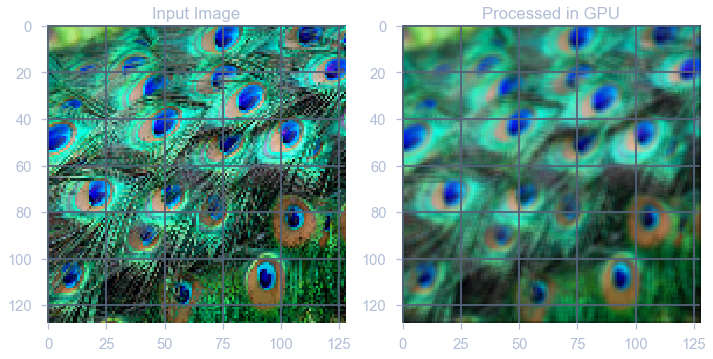

In [84]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1], cmap='gray')
plt.title("Input Image")

plt.subplot(1,2,2)
plt.imshow(outputImage[0][:,:,::-1].astype('uint8'), cmap='gray')
plt.title("Processed in GPU")
plt.tight_layout()
plt.show()